<a href="https://colab.research.google.com/github/Drdddd-www/CS-BAOYAN/blob/main/AI_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.simplefilter('ignore')

import os
import gc

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from tqdm.auto import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_log_error

import lightgbm as lgb

from matplotlib.pyplot import plot, show

In [2]:
roles = pd.read_csv('submission_sample.csv')

# 共七天, roles表填充完整; data记录每个role_id每天的特征值
dfs = []
for i in range(2, 9):
    tmp = roles.copy()
    tmp['day'] = i
    dfs.append(tmp)
data = pd.concat(dfs).reset_index(drop=True)
data.drop(['pay'], axis=1, inplace=True)

In [3]:
data

,role_id,day
0,bad0cf6b7b108dbf49c37e82,2
1,6db8b5b88a760d77892575da,2
2,61ba0ef6872ad6fbccb2903e,2
3,2cef142a894dfd7e9fc86c55,2
4,f9a8abd9d193e4feb6665ff6,2
...,...,...
27393,571d8b3d2151d9e6afcd43ee,8
27394,1d35e12f81f14451fa8e02ef,8
27395,c3c5c061feab3e7b145b0288,8
27396,50485dbc5105a29d0c24b0b3,8


In [4]:
# 货币消耗表
consume = pd.read_csv('role_consume_op.csv')
consume['dt'] = pd.to_datetime(consume['dt'])
consume['day'] = consume['dt'].dt.day

# t3,t4货币几乎没有消耗记录，在此不做考虑
# t1,t2货币消耗按天合并，count/sum记录每天消耗货币的次数/总值
for i in range(1, 3):
    for m in ['count', 'sum']:
        tmp = consume.groupby(['role_id', 'day'])[f'use_t{i}'].agg(m).to_frame(name=f'use_t{i}_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')
# t2货币库存量
tmp = consume.groupby(['role_id', 'day'])['use_t2'].agg('last').to_frame(name='use_t2_last').reset_index()
data = data.merge(tmp, on=['role_id', 'day'], how='left')
# 用户每天等级
tmp = consume.groupby(['role_id', 'day'])['level'].agg('last').to_frame(name='rlevel_last').reset_index()
data = data.merge(tmp, on=['role_id', 'day'], how='left')

data

,role_id,day,use_t1_count,use_t1_sum,use_t2_count,use_t2_sum,use_t2_last,rlevel_last
0,bad0cf6b7b108dbf49c37e82,2,93.0,-530.0,93.0,-46.0,0.0,344.0
1,6db8b5b88a760d77892575da,2,NaN,NaN,NaN,NaN,NaN,NaN
2,61ba0ef6872ad6fbccb2903e,2,26.0,824.0,26.0,20.0,0.0,397.0
3,2cef142a894dfd7e9fc86c55,2,65.0,-147.0,65.0,-50.0,0.0,369.0
4,f9a8abd9d193e4feb6665ff6,2,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
27393,571d8b3d2151d9e6afcd43ee,8,26.0,-12.0,26.0,0.0,0.0,525.0
27394,1d35e12f81f14451fa8e02ef,8,NaN,NaN,NaN,NaN,NaN,NaN
27395,c3c5c061feab3e7b145b0288,8,27.0,-306.0,27.0,0.0,0.0,274.0
27396,50485dbc5105a29d0c24b0b3,8,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 道具升级表
evolve = pd.read_csv('role_evolve_op.csv')
evolve['dt'] = pd.to_datetime(evolve['dt'])
evolve['day'] = evolve['dt'].dt.day
evolve['n_level_up'] = evolve['new_lv'] - evolve['old_lv']
evolve = evolve.rename(columns={'num': 'lv_consume_item_num'})

# 每天升级道具次数和类型个数
for m in ['count', 'nunique']:
    tmp = evolve.groupby(['role_id', 'day'])['item_id'].agg(m).to_frame(name=f'item_id_{m}').reset_index()
    data = data.merge(tmp, on=['role_id', 'day'], how='left')

# 每天升级道具（平均）消耗和提升（平均）级数
for col in ['lv_consume_item_num', 'n_level_up']:
    for m in ['sum', 'mean']:
        tmp = evolve.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')

data

,role_id,day,use_t1_count,use_t1_sum,use_t2_count,use_t2_sum,use_t2_last,rlevel_last,item_id_count,item_id_nunique,lv_consume_item_num_sum,lv_consume_item_num_mean,n_level_up_sum,n_level_up_mean
0,bad0cf6b7b108dbf49c37e82,2,93.0,-530.0,93.0,-46.0,0.0,344.0,181.0,12.0,251.0,1.386740,21.0,0.116022
1,6db8b5b88a760d77892575da,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,61ba0ef6872ad6fbccb2903e,2,26.0,824.0,26.0,20.0,0.0,397.0,15.0,7.0,65.0,4.333333,4.0,0.266667
3,2cef142a894dfd7e9fc86c55,2,65.0,-147.0,65.0,-50.0,0.0,369.0,114.0,8.0,142.0,1.245614,14.0,0.122807
4,f9a8abd9d193e4feb6665ff6,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27393,571d8b3d2151d9e6afcd43ee,8,26.0,-12.0,26.0,0.0,0.0,525.0,14.0,3.0,101.0,7.214286,3.0,0.214286
27394,1d35e12f81f14451fa8e02ef,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27395,c3c5c061feab3e7b145b0288,8,27.0,-306.0,27.0,0.0,0.0,274.0,22.0,8.0,91.0,4.136364,16.0,0.727273
27396,50485dbc5105a29d0c24b0b3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# 付费表
pay = pd.read_csv('role_pay.csv')
pay['dt'] = pd.to_datetime(pay['dt'])
pay['day'] = pay['dt'].dt.day
for m in ['sum', 'count']:
  tmp = pay.groupby(['role_id', 'day'])['pay'].agg(m).to_frame(name=f'pay_{m}').reset_index()
  data = data.merge(tmp, on=['role_id', 'day'], how='left')

data

,role_id,day,use_t1_count,use_t1_sum,use_t2_count,use_t2_sum,use_t2_last,rlevel_last,item_id_count,item_id_nunique,lv_consume_item_num_sum,lv_consume_item_num_mean,n_level_up_sum,n_level_up_mean,pay_sum,pay_count
0,bad0cf6b7b108dbf49c37e82,2,93.0,-530.0,93.0,-46.0,0.0,344.0,181.0,12.0,251.0,1.386740,21.0,0.116022,74.0,2.0
1,6db8b5b88a760d77892575da,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,61ba0ef6872ad6fbccb2903e,2,26.0,824.0,26.0,20.0,0.0,397.0,15.0,7.0,65.0,4.333333,4.0,0.266667,NaN,NaN
3,2cef142a894dfd7e9fc86c55,2,65.0,-147.0,65.0,-50.0,0.0,369.0,114.0,8.0,142.0,1.245614,14.0,0.122807,6.0,1.0
4,f9a8abd9d193e4feb6665ff6,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27393,571d8b3d2151d9e6afcd43ee,8,26.0,-12.0,26.0,0.0,0.0,525.0,14.0,3.0,101.0,7.214286,3.0,0.214286,NaN,NaN
27394,1d35e12f81f14451fa8e02ef,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27395,c3c5c061feab3e7b145b0288,8,27.0,-306.0,27.0,0.0,0.0,274.0,22.0,8.0,91.0,4.136364,16.0,0.727273,NaN,NaN
27396,50485dbc5105a29d0c24b0b3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# 副本表
fb = pd.read_csv('role_fb_op.csv')
fb['dt'] = pd.to_datetime(fb['dt'])
fb['day'] = fb['dt'].dt.day
fb['fb_used_time'] = fb['finish_time'] - fb['start_time']

# 玩家每天挑战副本次数以及失败/中途放弃次数
tmp = fb.groupby(['role_id', 'day'])['fb_result'].agg('count').to_frame(name='challenge_count').reset_index()
data = data.merge(tmp, on=['role_id', 'day'], how='left')
tmp = fb[fb['fb_result'].astype(int) == 0].groupby(['role_id', 'day'])['fb_type'].agg('count').to_frame(name='fb_result0_count').reset_index()
data = data.merge(tmp, on=['role_id', 'day'], how='left')
tmp = fb[fb['fb_result'].astype(int) == 2].groupby(['role_id', 'day'])['fb_type'].agg('count').to_frame(name='fb_result2_count').reset_index()
data = data.merge(tmp, on=['role_id', 'day'], how='left')
# 玩家每天挑战副本的（平均）时长和经验
for col in ['fb_used_time', 'exp']:
    for m in ['sum', 'mean']:
        tmp = fb.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')
data

,role_id,day,use_t1_count,use_t1_sum,use_t2_count,use_t2_sum,use_t2_last,rlevel_last,item_id_count,item_id_nunique,lv_consume_item_num_sum,lv_consume_item_num_mean,n_level_up_sum,n_level_up_mean,pay_sum,pay_count,challenge_count,fb_result0_count,fb_result2_count,fb_used_time_sum,fb_used_time_mean,exp_sum,exp_mean
0,bad0cf6b7b108dbf49c37e82,2,93.0,-530.0,93.0,-46.0,0.0,344.0,181.0,12.0,251.0,1.386740,21.0,0.116022,74.0,2.0,30.0,10.0,NaN,4998.0,166.600000,1.049034e+09,3.496781e+07
1,6db8b5b88a760d77892575da,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,61ba0ef6872ad6fbccb2903e,2,26.0,824.0,26.0,20.0,0.0,397.0,15.0,7.0,65.0,4.333333,4.0,0.266667,NaN,NaN,12.0,2.0,9.0,202.0,16.833333,3.034000e+09,2.528333e+08
3,2cef142a894dfd7e9fc86c55,2,65.0,-147.0,65.0,-50.0,0.0,369.0,114.0,8.0,142.0,1.245614,14.0,0.122807,6.0,1.0,27.0,9.0,7.0,3567.0,132.111111,2.946200e+09,1.091185e+08
4,f9a8abd9d193e4feb6665ff6,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27393,571d8b3d2151d9e6afcd43ee,8,26.0,-12.0,26.0,0.0,0.0,525.0,14.0,3.0,101.0,7.214286,3.0,0.214286,NaN,NaN,11.0,2.0,5.0,412.0,37.454545,1.840320e+10,1.673018e+09
27394,1d35e12f81f14451fa8e02ef,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27395,c3c5c061feab3e7b145b0288,8,27.0,-306.0,27.0,0.0,0.0,274.0,22.0,8.0,91.0,4.136364,16.0,0.727273,NaN,NaN,16.0,5.0,NaN,1455.0,90.937500,6.005927e+08,3.753705e+07
27396,50485dbc5105a29d0c24b0b3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# 任务系统表
mission = pd.read_csv('role_mission_op.csv')
mission['dt'] = pd.to_datetime(mission['dt'])
mission['day'] = mission['dt'].dt.day

# 用户每天完成过任务2001或3001或3002或3003的总次数
tmp = mission[(mission['mission_type'].astype(int) == 2001) | (mission['mission_type'].astype(int) == 3001) | (mission['mission_type'].astype(int) == 3002) | (mission['mission_type'].astype(int) == 3003)
].groupby(['role_id', 'day'])['mission_id'].agg('count').to_frame(name='mission_count').reset_index()

data = data.merge(tmp, on=['role_id', 'day'], how='left')
# 用户每天完成任务状态为1/2的总次数
tmp = mission[mission['mission_status'].astype(int) == 1].groupby(['role_id', 'day'])['mission_id'].agg('count').to_frame(name='mission_s1_count').reset_index()
data = data.merge(tmp, on=['role_id', 'day'], how='left')
tmp = mission[mission['mission_status'].astype(int) == 2].groupby(['role_id', 'day'])['mission_id'].agg('count').to_frame(name='mission_s2_count').reset_index()
data = data.merge(tmp, on=['role_id', 'day'], how='left')

data

,role_id,day,use_t1_count,use_t1_sum,use_t2_count,use_t2_sum,use_t2_last,rlevel_last,item_id_count,item_id_nunique,lv_consume_item_num_sum,lv_consume_item_num_mean,n_level_up_sum,n_level_up_mean,pay_sum,pay_count,challenge_count,fb_result0_count,fb_result2_count,fb_used_time_sum,fb_used_time_mean,exp_sum,exp_mean,mission_count,mission_s1_count,mission_s2_count
0,bad0cf6b7b108dbf49c37e82,2,93.0,-530.0,93.0,-46.0,0.0,344.0,181.0,12.0,251.0,1.386740,21.0,0.116022,74.0,2.0,30.0,10.0,NaN,4998.0,166.600000,1.049034e+09,3.496781e+07,NaN,9.0,4.0
1,6db8b5b88a760d77892575da,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,61ba0ef6872ad6fbccb2903e,2,26.0,824.0,26.0,20.0,0.0,397.0,15.0,7.0,65.0,4.333333,4.0,0.266667,NaN,NaN,12.0,2.0,9.0,202.0,16.833333,3.034000e+09,2.528333e+08,NaN,4.0,1.0
3,2cef142a894dfd7e9fc86c55,2,65.0,-147.0,65.0,-50.0,0.0,369.0,114.0,8.0,142.0,1.245614,14.0,0.122807,6.0,1.0,27.0,9.0,7.0,3567.0,132.111111,2.946200e+09,1.091185e+08,NaN,10.0,4.0
4,f9a8abd9d193e4feb6665ff6,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27393,571d8b3d2151d9e6afcd43ee,8,26.0,-12.0,26.0,0.0,0.0,525.0,14.0,3.0,101.0,7.214286,3.0,0.214286,NaN,NaN,11.0,2.0,5.0,412.0,37.454545,1.840320e+10,1.673018e+09,NaN,NaN,NaN
27394,1d35e12f81f14451fa8e02ef,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27395,c3c5c061feab3e7b145b0288,8,27.0,-306.0,27.0,0.0,0.0,274.0,22.0,8.0,91.0,4.136364,16.0,0.727273,NaN,NaN,16.0,5.0,NaN,1455.0,90.937500,6.005927e+08,3.753705e+07,NaN,4.0,2.0
27396,50485dbc5105a29d0c24b0b3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# 玩家离线表
offline = pd.read_csv('role_offline_op.csv')
offline['dt'] = pd.to_datetime(mission['dt'])
offline['day'] = offline['dt'].dt.day
offline['online_durations'] = offline['offline'] - offline['online']
# 用户下线理由/地图类型数
for col in ['reason', 'map_id']:
    tmp = offline.groupby(['role_id', 'day'])[col].agg('nunique').to_frame(name=f'{col}_nunique').reset_index()
    data = data.merge(tmp, on=['role_id', 'day'], how='left')
# 用户上线总时长/上线次数
for col in ['online_durations']:
    for m in ['sum', 'count']:
        tmp = offline.groupby(['role_id', 'day'])[col].agg(m).to_frame(name=f'{col}_{m}').reset_index()
        data = data.merge(tmp, on=['role_id', 'day'], how='left')
data

,role_id,day,use_t1_count,use_t1_sum,use_t2_count,use_t2_sum,use_t2_last,rlevel_last,item_id_count,item_id_nunique,lv_consume_item_num_sum,lv_consume_item_num_mean,n_level_up_sum,n_level_up_mean,pay_sum,pay_count,challenge_count,fb_result0_count,fb_result2_count,fb_used_time_sum,fb_used_time_mean,exp_sum,exp_mean,mission_count,mission_s1_count,mission_s2_count,reason_nunique,map_id_nunique,online_durations_sum,online_durations_count
0,bad0cf6b7b108dbf49c37e82,2,93.0,-530.0,93.0,-46.0,0.0,344.0,181.0,12.0,251.0,1.386740,21.0,0.116022,74.0,2.0,30.0,10.0,NaN,4998.0,166.600000,1.049034e+09,3.496781e+07,NaN,9.0,4.0,5.0,12.0,73192.0,99.0
1,6db8b5b88a760d77892575da,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,17213.0,12.0
2,61ba0ef6872ad6fbccb2903e,2,26.0,824.0,26.0,20.0,0.0,397.0,15.0,7.0,65.0,4.333333,4.0,0.266667,NaN,NaN,12.0,2.0,9.0,202.0,16.833333,3.034000e+09,2.528333e+08,NaN,4.0,1.0,3.0,5.0,22149.0,14.0
3,2cef142a894dfd7e9fc86c55,2,65.0,-147.0,65.0,-50.0,0.0,369.0,114.0,8.0,142.0,1.245614,14.0,0.122807,6.0,1.0,27.0,9.0,7.0,3567.0,132.111111,2.946200e+09,1.091185e+08,NaN,10.0,4.0,1.0,10.0,74314.0,56.0
4,f9a8abd9d193e4feb6665ff6,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4573.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27393,571d8b3d2151d9e6afcd43ee,8,26.0,-12.0,26.0,0.0,0.0,525.0,14.0,3.0,101.0,7.214286,3.0,0.214286,NaN,NaN,11.0,2.0,5.0,412.0,37.454545,1.840320e+10,1.673018e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27394,1d35e12f81f14451fa8e02ef,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27395,c3c5c061feab3e7b145b0288,8,27.0,-306.0,27.0,0.0,0.0,274.0,22.0,8.0,91.0,4.136364,16.0,0.727273,NaN,NaN,16.0,5.0,NaN,1455.0,90.937500,6.005927e+08,3.753705e+07,NaN,4.0,2.0,NaN,NaN,NaN,NaN
27396,50485dbc5105a29d0c24b0b3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# 用户每日下线原因（多个原因选择次数最多的）
tmp = offline.groupby(['role_id', 'day'])['reason'].apply(lambda x: x.value_counts().idxmax()).reset_index()
data = data.merge(tmp, on=['role_id', 'day'], how='left')
# 用户每日下线地图（多个地图选择次数最多的）
tmp = offline.groupby(['role_id', 'day'])['map_id'].apply(lambda x: x.value_counts().idxmax()).reset_index()
data = data.merge(tmp, on=['role_id', 'day'], how='left')
data

,role_id,day,use_t1_count,use_t1_sum,use_t2_count,use_t2_sum,use_t2_last,rlevel_last,item_id_count,item_id_nunique,lv_consume_item_num_sum,lv_consume_item_num_mean,n_level_up_sum,n_level_up_mean,pay_sum,pay_count,challenge_count,fb_result0_count,fb_result2_count,fb_used_time_sum,fb_used_time_mean,exp_sum,exp_mean,mission_count,mission_s1_count,mission_s2_count,reason_nunique,map_id_nunique,online_durations_sum,online_durations_count,reason,map_id
0,bad0cf6b7b108dbf49c37e82,2,93.0,-530.0,93.0,-46.0,0.0,344.0,181.0,12.0,251.0,1.386740,21.0,0.116022,74.0,2.0,30.0,10.0,NaN,4998.0,166.600000,1.049034e+09,3.496781e+07,NaN,9.0,4.0,5.0,12.0,73192.0,99.0,10014.0,40000.0
1,6db8b5b88a760d77892575da,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,17213.0,12.0,10014.0,40000.0
2,61ba0ef6872ad6fbccb2903e,2,26.0,824.0,26.0,20.0,0.0,397.0,15.0,7.0,65.0,4.333333,4.0,0.266667,NaN,NaN,12.0,2.0,9.0,202.0,16.833333,3.034000e+09,2.528333e+08,NaN,4.0,1.0,3.0,5.0,22149.0,14.0,10014.0,40000.0
3,2cef142a894dfd7e9fc86c55,2,65.0,-147.0,65.0,-50.0,0.0,369.0,114.0,8.0,142.0,1.245614,14.0,0.122807,6.0,1.0,27.0,9.0,7.0,3567.0,132.111111,2.946200e+09,1.091185e+08,NaN,10.0,4.0,1.0,10.0,74314.0,56.0,10014.0,40000.0
4,f9a8abd9d193e4feb6665ff6,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4573.0,9.0,10014.0,41001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27393,571d8b3d2151d9e6afcd43ee,8,26.0,-12.0,26.0,0.0,0.0,525.0,14.0,3.0,101.0,7.214286,3.0,0.214286,NaN,NaN,11.0,2.0,5.0,412.0,37.454545,1.840320e+10,1.673018e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27394,1d35e12f81f14451fa8e02ef,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27395,c3c5c061feab3e7b145b0288,8,27.0,-306.0,27.0,0.0,0.0,274.0,22.0,8.0,91.0,4.136364,16.0,0.727273,NaN,NaN,16.0,5.0,NaN,1455.0,90.937500,6.005927e+08,3.753705e+07,NaN,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
27396,50485dbc5105a29d0c24b0b3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
data['pay_sum'].fillna(0., inplace=True)
data

,role_id,day,use_t1_count,use_t1_sum,use_t2_count,use_t2_sum,use_t2_last,rlevel_last,item_id_count,item_id_nunique,lv_consume_item_num_sum,lv_consume_item_num_mean,n_level_up_sum,n_level_up_mean,pay_sum,pay_count,challenge_count,fb_result0_count,fb_result2_count,fb_used_time_sum,fb_used_time_mean,exp_sum,exp_mean,mission_count,mission_s1_count,mission_s2_count,reason_nunique,map_id_nunique,online_durations_sum,online_durations_count,reason,map_id
0,bad0cf6b7b108dbf49c37e82,2,93.0,-530.0,93.0,-46.0,0.0,344.0,181.0,12.0,251.0,1.386740,21.0,0.116022,74.0,2.0,30.0,10.0,NaN,4998.0,166.600000,1.049034e+09,3.496781e+07,NaN,9.0,4.0,5.0,12.0,73192.0,99.0,10014.0,40000.0
1,6db8b5b88a760d77892575da,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,17213.0,12.0,10014.0,40000.0
2,61ba0ef6872ad6fbccb2903e,2,26.0,824.0,26.0,20.0,0.0,397.0,15.0,7.0,65.0,4.333333,4.0,0.266667,0.0,NaN,12.0,2.0,9.0,202.0,16.833333,3.034000e+09,2.528333e+08,NaN,4.0,1.0,3.0,5.0,22149.0,14.0,10014.0,40000.0
3,2cef142a894dfd7e9fc86c55,2,65.0,-147.0,65.0,-50.0,0.0,369.0,114.0,8.0,142.0,1.245614,14.0,0.122807,6.0,1.0,27.0,9.0,7.0,3567.0,132.111111,2.946200e+09,1.091185e+08,NaN,10.0,4.0,1.0,10.0,74314.0,56.0,10014.0,40000.0
4,f9a8abd9d193e4feb6665ff6,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,4.0,4573.0,9.0,10014.0,41001.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27393,571d8b3d2151d9e6afcd43ee,8,26.0,-12.0,26.0,0.0,0.0,525.0,14.0,3.0,101.0,7.214286,3.0,0.214286,0.0,NaN,11.0,2.0,5.0,412.0,37.454545,1.840320e+10,1.673018e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27394,1d35e12f81f14451fa8e02ef,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27395,c3c5c061feab3e7b145b0288,8,27.0,-306.0,27.0,0.0,0.0,274.0,22.0,8.0,91.0,4.136364,16.0,0.727273,0.0,NaN,16.0,5.0,NaN,1455.0,90.937500,6.005927e+08,3.753705e+07,NaN,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
27396,50485dbc5105a29d0c24b0b3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# 验证集设置
# 现在我们可以把问题转为用前n天的行为来预测第n+1天的付费

# 训练集 day 2,3,4,5,6 -> 标签 day 7 pay_sum
df_train = pd.DataFrame({'role_id': data.role_id.unique().tolist()})
for i, d in enumerate(range(2, 7)):
    tmp = data[data.day == d].copy().reset_index(drop=True)
    tmp.drop(['day'], axis=1, inplace=True)
    tmp.columns = ['role_id'] + [f'{c}_day{i}' for c in tmp.columns[1:]]
    df_train = df_train.merge(tmp, on='role_id')

# 验证集 day 3,4,5,6,7 -> 标签 day 8 pay_sum
df_valid = pd.DataFrame({'role_id': data.role_id.unique().tolist()})
for i, d in enumerate(range(3, 8)):
    tmp = data[data.day == d].copy().reset_index(drop=True)
    tmp.drop(['day'], axis=1, inplace=True)
    tmp.columns = ['role_id'] + [f'{c}_day{i}' for c in tmp.columns[1:]]
    df_valid = df_valid.merge(tmp, on='role_id')

# 测试集 day 4,5,6,7,8
df_test = pd.DataFrame({'role_id': data.role_id.unique().tolist()})
for i, d in enumerate(range(4, 9)):
    tmp = data[data.day == d].copy().reset_index(drop=True)
    tmp.drop(['day'], axis=1, inplace=True)
    tmp.columns = ['role_id'] + [f'{c}_day{i}' for c in tmp.columns[1:]]
    df_test = df_test.merge(tmp, on='role_id')

In [13]:
df_train

,role_id,use_t1_count_day0,use_t1_sum_day0,use_t2_count_day0,use_t2_sum_day0,use_t2_last_day0,rlevel_last_day0,item_id_count_day0,item_id_nunique_day0,lv_consume_item_num_sum_day0,lv_consume_item_num_mean_day0,n_level_up_sum_day0,n_level_up_mean_day0,challenge_count_day0,fb_result0_count_day0,fb_result2_count_day0,fb_used_time_sum_day0,fb_used_time_mean_day0,exp_sum_day0,exp_mean_day0,mission_count_day0,mission_s1_count_day0,mission_s2_count_day0,reason_nunique_day0,map_id_nunique_day0,online_durations_sum_day0,online_durations_count_day0,reason_day0,map_id_day0,pay_sum_day0,pay_count_day0,use_t1_count_day1,use_t1_sum_day1,use_t2_count_day1,use_t2_sum_day1,use_t2_last_day1,rlevel_last_day1,item_id_count_day1,item_id_nunique_day1,lv_consume_item_num_sum_day1,lv_consume_item_num_mean_day1,n_level_up_sum_day1,n_level_up_mean_day1,challenge_count_day1,fb_result0_count_day1,fb_result2_count_day1,fb_used_time_sum_day1,fb_used_time_mean_day1,exp_sum_day1,exp_mean_day1,mission_count_day1,mission_s1_count_day1,mission_s2_count_day1,reason_nunique_day1,map_id_nunique_day1,online_durations_sum_day1,online_durations_count_day1,reason_day1,map_id_day1,pay_sum_day1,pay_count_day1,use_t1_count_day2,use_t1_sum_day2,use_t2_count_day2,use_t2_sum_day2,use_t2_last_day2,rlevel_last_day2,item_id_count_day2,item_id_nunique_day2,lv_consume_item_num_sum_day2,lv_consume_item_num_mean_day2,n_level_up_sum_day2,n_level_up_mean_day2,challenge_count_day2,fb_result0_count_day2,fb_result2_count_day2,fb_used_time_sum_day2,fb_used_time_mean_day2,exp_sum_day2,exp_mean_day2,mission_count_day2,mission_s1_count_day2,mission_s2_count_day2,reason_nunique_day2,map_id_nunique_day2,online_durations_sum_day2,online_durations_count_day2,reason_day2,map_id_day2,pay_sum_day2,pay_count_day2,use_t1_count_day3,use_t1_sum_day3,use_t2_count_day3,use_t2_sum_day3,use_t2_last_day3,rlevel_last_day3,item_id_count_day3,item_id_nunique_day3,lv_consume_item_num_sum_day3,lv_consume_item_num_mean_day3,n_level_up_sum_day3,n_level_up_mean_day3,challenge_count_day3,fb_result0_count_day3,fb_result2_count_day3,fb_used_time_sum_day3,fb_used_time_mean_day3,exp_sum_day3,exp_mean_day3,mission_count_day3,mission_s1_count_day3,mission_s2_count_day3,reason_nunique_day3,map_id_nunique_day3,online_durations_sum_day3,online_durations_count_day3,reason_day3,map_id_day3,pay_sum_day3,pay_count_day3,use_t1_count_day4,use_t1_sum_day4,use_t2_count_day4,use_t2_sum_day4,use_t2_last_day4,rlevel_last_day4,item_id_count_day4,item_id_nunique_day4,lv_consume_item_num_sum_day4,lv_consume_item_num_mean_day4,n_level_up_sum_day4,n_level_up_mean_day4,challenge_count_day4,fb_result0_count_day4,fb_result2_count_day4,fb_used_time_sum_day4,fb_used_time_mean_day4,exp_sum_day4,exp_mean_day4,mission_count_day4,mission_s1_count_day4,mission_s2_count_day4,reason_nunique_day4,map_id_nunique_day4,online_durations_sum_day4,online_durations_count_day4,reason_day4,map_id_day4,pay_sum_day4,pay_count_day4
0,28b9114a5784b724997257c3,1.0,-398.0,1.0,0.0,0.0,356.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,705.0,2.0,10021.0,40000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,51d43143f0e8c695792ee1d4,31.0,135.0,31.0,0.0,0.0,301.0,49.0,4.0,49.0,1.0,6.0,0.122449,6.0,3.0,NaN,707.0,117.833333,1.366090e+08,2.276817e+07,NaN,NaN,NaN,3.0,3.0,4012.0,3.0,10021.0,81601.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [14]:
# 标签构造

# 训练集 day == 7 pay_sum
# 验证集 day == 8 pay_sum

day7_pay = pay[pay.day == 7].copy().reset_index(drop=True)
tmp = day7_pay.groupby('role_id')['pay'].agg('sum').to_frame(name='pay').reset_index()
df_train = df_train.merge(tmp, on='role_id', how='left')
df_train['pay'].fillna(0., inplace=True)

day8_pay = pay[pay.day == 8].copy().reset_index(drop=True)
tmp = day8_pay.groupby('role_id')['pay'].agg('sum').to_frame(name='pay').reset_index()
df_valid = df_valid.merge(tmp, on='role_id', how='left')
df_valid['pay'].fillna(0., inplace=True)


In [15]:
df = pd.concat([df_train, df_valid, df_test]).reset_index(drop=True)

df['pay_log'] = np.log1p(df['pay'])
df_train = df[:len(df_train)].reset_index(drop=True)
df_valid = df[len(df_train):len(df_train) + len(df_valid)].reset_index(drop=True)
df_test = df[-len(df_test):].reset_index(drop=True)
params = {
    'objective': 'regression',
    'metric': {'rmse'},
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'max_depth': 12,
    'num_leaves': 32,
    'feature_fraction': 0.70,
    'subsample': 0.75,
    'seed': 114,
    'num_iterations': 3000,
    'nthread': -1,
    'verbose': -1
}

features = [col for col in df_train.columns if col not in ['role_id', 'pay', 'pay_log']]
len(features)

150

In [16]:
def train(df_train, df_valid, label, params, features):
    '''
    训练函数
    Args:
        df_train (DataFrame): 训练数据集
        df_valid (DataFrame): 验证数据集
        label (str): 目标变量列名
        params (dict): LightGBM模型参数字典
        features (list): 用于训练的特征列名列表
    Returns:
        clf (model): 训练好的模型
        result (float): 模型评估结果
    '''
    # 训练集的特征和标签
    train_label = df_train[label].values
    train_feat = df_train[features]

    # 验证集的特征和标签
    valid_label = df_valid[label].values
    valid_feat = df_valid[features]
    # 垃圾回收以释放内存
    gc.collect()

    # 转换为LightGBM的数据集类型
    trn_data = lgb.Dataset(train_feat, label=train_label)
    val_data = lgb.Dataset(valid_feat, label=valid_label)

    # 定义回调函数，用于记录训练过程和早期停止
    from lightgbm import log_evaluation, early_stopping
    callbacks = [log_evaluation(period=50), early_stopping(stopping_rounds=100)]

    # 训练LightGBM模型
    clf = lgb.train(params,trn_data,valid_sets=[trn_data, val_data],callbacks=callbacks)

    # 创建一个DataFrame用于存储特征重要性信息
    fold_importance_df = pd.DataFrame()

    # 计算并存储模型中各个特征的重要性
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()

    # 计算并存储模型中各个特征的增益重要性
    fold_importance_df["importance_gain"] = clf.feature_importance(importance_type='gain')

    # 按重要性降序排列
    fold_importance_df = fold_importance_df.sort_values(by='importance', ascending=False)

    # 打印前30个重要特征
    print(fold_importance_df[:30])

    # 使用模型对验证集进行预测
    df_valid['{}_preds'.format(label)] = clf.predict(valid_feat, num_iteration=clf.best_iteration)

    # 负值修正，将小于0的值设置为0
    df_valid['{}_preds'.format(label)] = df_valid['{}_preds'.format(label)].clip(lower=0.)

    # 计算模型的评估指标，这里使用均方对数误差（MSLE）
    result = mean_squared_log_error(np.expm1(df_valid[label]),
                                    np.expm1(df_valid['{}_preds'.format(label)]))

    # 可视化验证集的真实目标和预测结果
    plot(np.expm1(df_valid[label]))
    plot(np.expm1(df_valid['{}_preds'.format(label)]))
    show()

    # 返回训练好的模型和评估结果
    return clf, result

Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.486201	valid_1's rmse: 0.613162
[100]	training's rmse: 0.405745	valid_1's rmse: 0.620545
Early stopping, best iteration is:
[39]	training's rmse: 0.518229	valid_1's rmse: 0.61091
                           Feature  importance  importance_gain
26       online_durations_sum_day0          83       674.730807
132                   pay_sum_day4          52      6830.605577
123                use_t2_sum_day4          36       320.758186
25             map_id_nunique_day0          31       221.687441
127           item_id_nunique_day4          26       325.702649
71            n_level_up_mean_day2          25       342.773458
129  lv_consume_item_num_mean_day4          24       100.839443
103                 pay_count_day3          24       887.601406
120              use_t1_count_day4          24       334.637785
137          fb_used_time_sum_day4          23       406.246990
91                 use_t1_sum_d

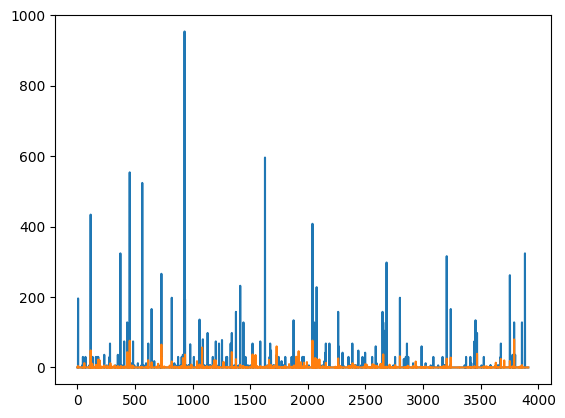

########################rmsle score 0.6108382749593955


In [17]:
clf_valid, result_valid = train(df_train, df_valid, 'pay_log', params, features)

print('########################rmsle score', np.sqrt(result_valid))

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[39]	training's rmse: 0.446341	valid_1's rmse: 0.446341
                           Feature  importance  importance_gain
93                 use_t2_sum_day3          49       287.074354
132                   pay_sum_day4          40      5938.565023
102                   pay_sum_day3          38      1845.698263
63                 use_t2_sum_day2          30       127.304149
107          fb_used_time_sum_day3          29       252.065670
128   lv_consume_item_num_sum_day4          28       156.383230
137          fb_used_time_sum_day4          26       420.686654
121                use_t1_sum_day4          25        79.431162
123                use_t2_sum_day4          25       132.185413
33                 use_t2_sum_day1          25       174.157372
143          mission_s2_count_day4          25       102.073046
126             item_id_count_day4          24       128.073496
13

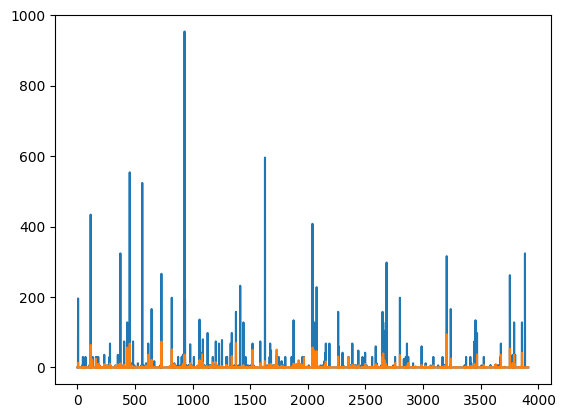

########################rmsle score 0.44633763732358256


In [18]:
# 用 4,5,6,7,8 重新训练模型
params['num_iterations'] = clf_valid.best_iteration
clf_test, result_test = train(df_valid, df_valid, 'pay_log', params, features)

print('########################rmsle score', np.sqrt(result_test))

In [19]:
df_test['pay'] = np.expm1(clf_test.predict(df_test[features]))
df_test['pay'] = df_test['pay'].clip(lower=0.)
df_test['pay'].describe()

count    3914.000000
mean        0.449874
std         2.643910
min         0.000000
25%         0.024931
50%         0.027774
75%         0.110789
max        59.880520
Name: pay, dtype: float64

In [20]:

sub = pd.read_csv('submission_sample.csv')
sub_df = df_test[['role_id', 'pay']].copy()
sub = sub[['role_id']].merge(sub_df, on='role_id', how='left')
sub[['role_id', 'pay']].to_csv('submission.csv', index=False)